# Forecasting electricity consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import mean_pinball_loss, mean_squared_error
from deeptcn import GaussianDeepTCN, QuantileDeepTCN, utils

## Dataset

The electricity dataset represents the electricity consumption of 370 clients recorded in 15-minutes periods in Kilowatt (kW). The original dataset is published here https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014. 

In [2]:
electricity_train, electricity_test = utils.electricity_dataset()

We split the time series into target and covariates.
* __target__ consists of the electricity consumption
* __covariates__ are positional encoding defined by a simple Fourier transformation: $cov[i] = \left[ \sin(2\pi i / 7), \cos(2\pi i / 7) \right]$, where $i$ is a day of a week.

In [3]:
train_target, train_cov = electricity_train.iloc[:, :370], electricity_train.iloc[:, 372:374]
test_target, test_cov = electricity_test.iloc[:, :370], electricity_test.iloc[:, 372:374]

train_target.shape, train_cov.shape, test_target.shape, test_cov.shape

((1081, 370), (1081, 2), (168, 370), (168, 2))

Let us plot 3 random customers from the train period.

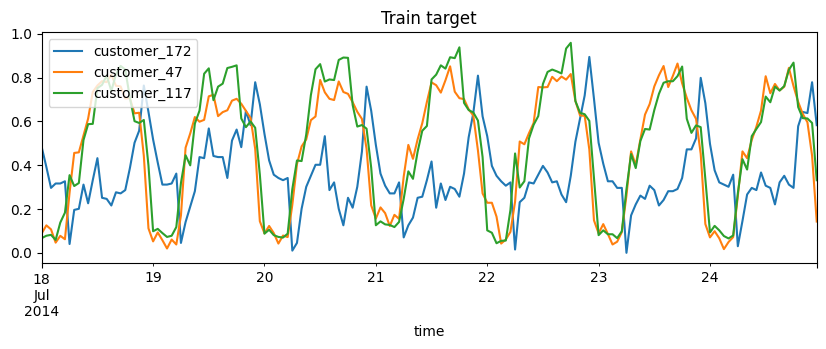

In [4]:
np.random.seed(0)
idx = np.random.randint(train_target.shape[1], size=3)
train_target.iloc[:168, idx].plot(figsize=(10, 3), title='Train target');

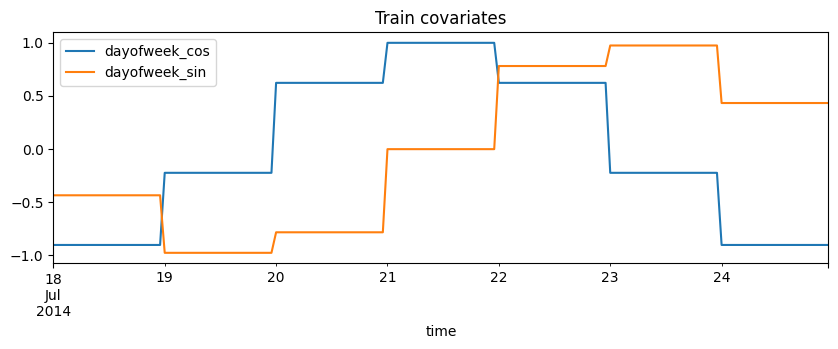

In [5]:
train_cov.iloc[:168].plot(figsize=(10, 3), title='Train covariates');

## Gaussian DeepTCN

We train Gaussian DeepTCN. We set the input length (context size, lookback window size) is 104, and the output length (forecasting horizon) is 64.

In [6]:
input_len = 104
output_len = 64

In [7]:
model = GaussianDeepTCN(
    input_len=input_len,
    output_len=output_len,
    hidden_dim=64,
    dropout=0.1,
    kernel_size=3, 
    num_layers=2, 
    lr=0.001, 
    batch_size=32, 
    num_epochs=10, 
    verbose=True,
    validation_size=0.,
    accelerator='cpu',
)
model.fit(train_target.values, future_covariates=train_cov.values)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vitaliypozdnyakov/miniconda3/envs/deeptcn/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/vitaliypozdnyakov/miniconda3/envs/deeptcn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name    | Type          | Params
------------------------------------------
0 | encoder | TCNModule     | 131 K 
1 | decoder | ResNetVModule | 4.4 K 
2 | output  | Linear        | 48.1 K
------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.737     Total estimated model params size (MB)
/Users/vitaliypozdnyakov/miniconda3/envs/deeptcn/lib/python3.10/sit

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


We split the test data into past and future periods. We try to predict future target using past target and future covariates.

In [8]:
past_target = test_target.iloc[:input_len]
future_cov = test_cov.iloc[input_len:]
future_target = test_target.iloc[input_len:]

Gaussian DeepTCN returns parameters of Gaussian distribution: mean and standard deviation. We use these parameters to calculate 80% confedence interval of a forecast by the percent point function (PPF).

In [9]:
pred_mu, pred_sigma = model.predict(past_target.values, future_covariates=future_cov.values)
pred_q01 = norm.ppf(q=0.1, loc=pred_mu, scale=pred_sigma)
pred_q05 = norm.ppf(q=0.5, loc=pred_mu, scale=pred_sigma)
pred_q09 = norm.ppf(q=0.9, loc=pred_mu, scale=pred_sigma)

Results.

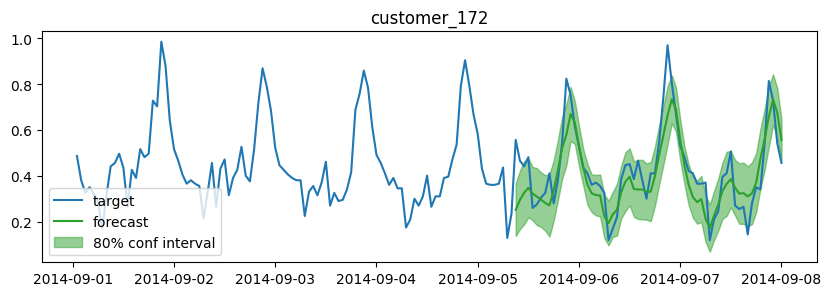

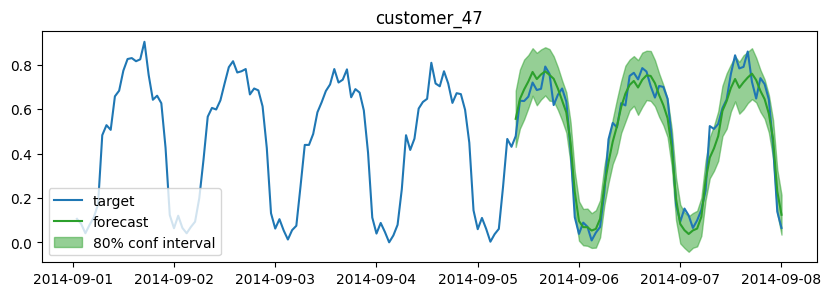

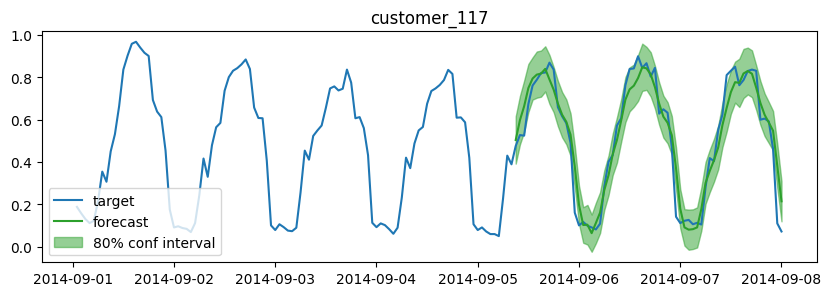

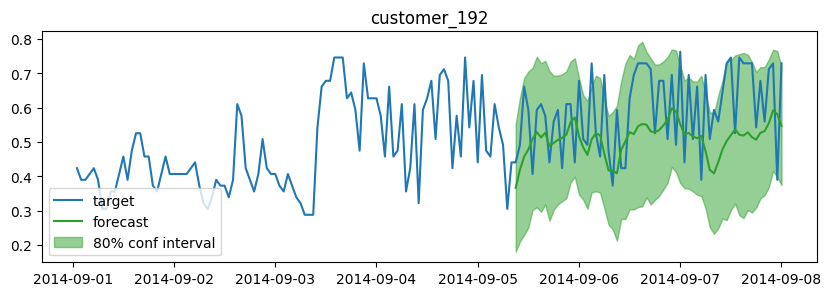

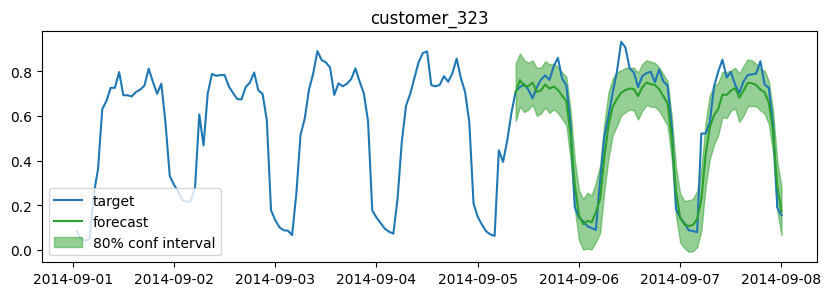

In [10]:
np.random.seed(0)
for i in np.random.randint(test_target.shape[1], size=5):
    plt.figure(figsize=(10, 3))
    plt.plot(test_target.iloc[:, i], label='target', c='tab:blue')
    plt.plot(
        future_target.index, 
        pred_q05[:, i],
        label='forecast', c='tab:green')
    plt.fill_between(
        x=test_target.index[input_len:],
        y1=pred_q01[:, i], y2=pred_q09[:, i], 
        label='80% conf interval', alpha=0.5, color='tab:green')
    plt.legend(loc='lower left')
    plt.title(test_target.columns[i])
    plt.show()

In [11]:
print(f'Pinball loss, alpha 0.1: {mean_pinball_loss(future_target, pred_q01, alpha=0.1):.4f}')
print(f'Pinball loss, alpha 0.5 (aka MAE): {mean_pinball_loss(future_target, pred_q05, alpha=0.5):.4f}')
print(f'Pinball loss, alpha 0.9: {mean_pinball_loss(future_target, pred_q09, alpha=0.9):.4f}')
print(f'MSE: {mean_squared_error(future_target, pred_q05):.4f}')

Pinball loss, alpha 0.1: 0.0215
Pinball loss, alpha 0.5 (aka MAE): 0.0489
Pinball loss, alpha 0.9: 0.0221
MSE: 0.0195


## Quantile DeepTCN

In [12]:
input_len = 104
output_len = 64

In [13]:
model = QuantileDeepTCN(
    input_len=input_len,
    output_len=output_len,
    hidden_dim=64,
    dropout=0.1,
    kernel_size=3, 
    num_layers=2, 
    lr=0.001, 
    batch_size=32, 
    num_epochs=10, 
    verbose=True,
    validation_size=0.,
    quantiles=[0.1, 0.5, 0.8],
    accelerator='cpu',
)
model.fit(train_target.values, future_covariates=train_cov.values)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vitaliypozdnyakov/miniconda3/envs/deeptcn/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/vitaliypozdnyakov/miniconda3/envs/deeptcn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name    | Type          | Params
------------------------------------------
0 | encoder | TCNModule     | 131 K 
1 | decoder | ResNetVModule | 4.4 K 
2 | output  | Linear        | 72.2 K
------------------------------------------
208 K     Trainable params
0         Non-trainable params
208 K     Total params
0.834     Total estimated model params size (MB)
/Users/vitaliypozdnyakov/miniconda3/envs/deeptcn/lib/python3.10/sit

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


Quantile DeepTCN returns quantiles for forecasting. We can use them to predict the confidence interval of a forecast.

In [14]:
pred_q01, pred_q05, pred_q09 = model.predict(past_target.values, future_covariates=future_cov.values)
pred_q01.shape

(64, 370)

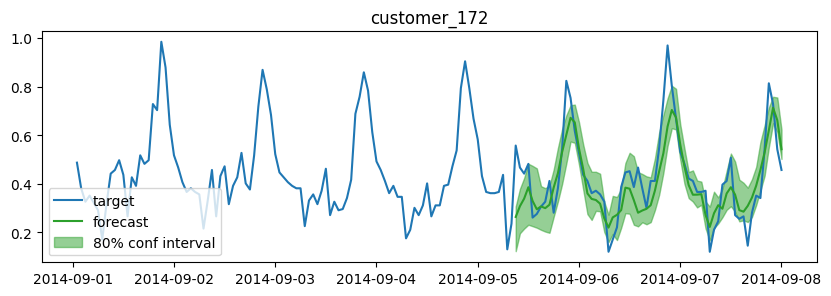

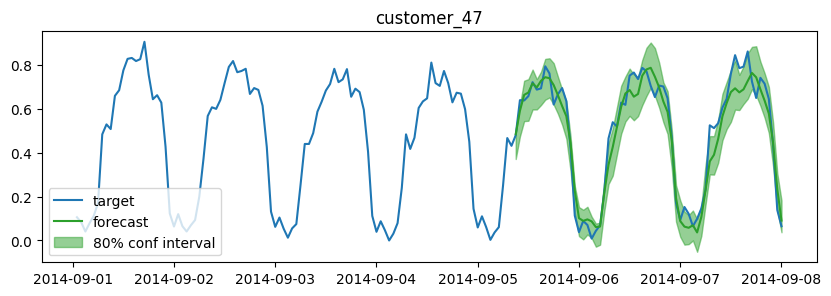

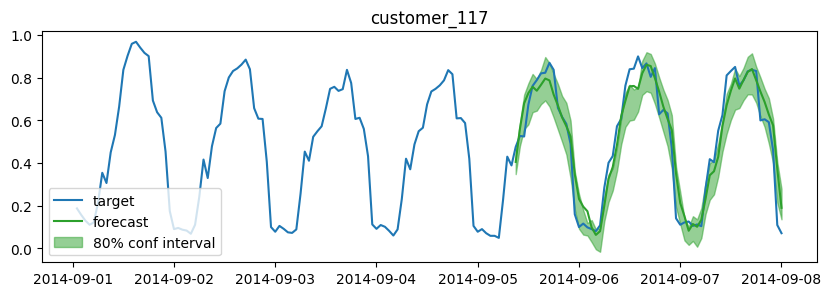

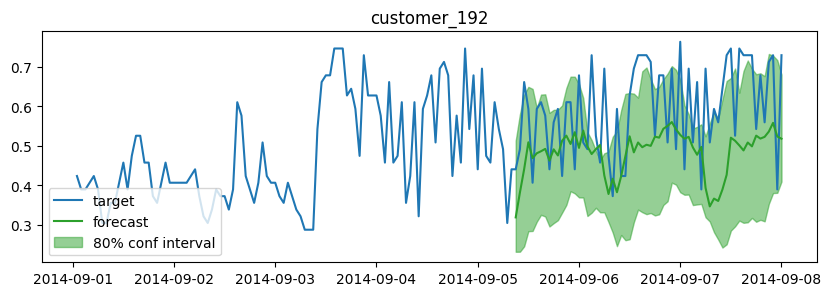

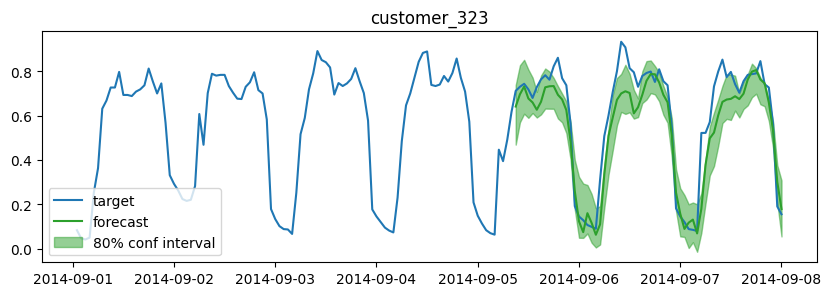

In [15]:
np.random.seed(0)
for i in np.random.randint(test_target.shape[1], size=5):
    plt.figure(figsize=(10, 3))
    plt.plot(test_target.iloc[:, i], label='target', c='tab:blue')
    plt.plot(
        future_target.index, 
        pred_q05[:, i],
        label='forecast', c='tab:green')
    plt.fill_between(
        x=test_target.index[input_len:],
        y1=pred_q01[:, i], y2=pred_q09[:, i], 
        label='80% conf interval', alpha=0.5, color='tab:green')
    plt.legend(loc='lower left')
    plt.title(test_target.columns[i])
    plt.show()

In [16]:
print(f'Pinball loss, alpha 0.1: {mean_pinball_loss(future_target, pred_q01, alpha=0.1):.4f}')
print(f'Pinball loss, alpha 0.5 (aka MAE): {mean_pinball_loss(future_target, pred_q05, alpha=0.5):.4f}')
print(f'Pinball loss, alpha 0.9: {mean_pinball_loss(future_target, pred_q09, alpha=0.9):.4f}')
print(f'MSE: {mean_squared_error(future_target, pred_q05):.4f}')

Pinball loss, alpha 0.1: 0.0220
Pinball loss, alpha 0.5 (aka MAE): 0.0529
Pinball loss, alpha 0.9: 0.0287
MSE: 0.0222
